# merge vs iteration

There are two approaches to substiting some values in a column based on values in another:
- Iterative approach: iterate through rows with `iterrows()`, and based on condition, substitute specific values;
- Merge: if you unpivot, you can merge. 

Merge is way faster, but here I would like to actually show that. 

In [153]:
import random 
from timeit import default_timer as timer
import warnings
import math

import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [154]:
random.seed(42)
warnings.filterwarnings('ignore')

In [155]:
[i for i in range(2015, 2020)]

[2015, 2016, 2017, 2018, 2019]

# Small sample

In [156]:
# Let's say we have the main file with data
df = pd.DataFrame({
    'Year': [i for i in range(2000, 2006)],
    'In-store purchase': [random.randint(0, 20) for i in range(5)] + [None],
    'Online purchase': [None] + [random.randint(0, 20) for i in range(5)]
})
df


,Year,In-store purchase,Online purchase
0,2000,20.0,NaN
1,2001,3.0,7.0
2,2002,0.0,4.0
3,2003,8.0,3.0
4,2004,7.0,17.0
5,2005,NaN,2.0


In [157]:
# And we also have data that we need to use to fill the main data file
df_prices = pd.DataFrame({
    'Year': [i for i in range(2000, 2006)] + [i for i in range(2000, 2006)],
    'Purchase': ['In-store purchase'] * 6 + ['Online purchase'] * 6,
    'Value': [5, 5, 10, 10, 10, 10] + [20, 21, 22, 22, 22, 22]
})
df_prices

,Year,Purchase,Value
0,2000,In-store purchase,5
1,2001,In-store purchase,5
2,2002,In-store purchase,10
3,2003,In-store purchase,10
4,2004,In-store purchase,10
5,2005,In-store purchase,10
6,2000,Online purchase,20
7,2001,Online purchase,21
8,2002,Online purchase,22
9,2003,Online purchase,22


## Approach 1: iterative

In [158]:
def proc_approach_1(df):
    df_filled_1 = df.copy(deep = True)

    for index, row in df_filled_1.iterrows():
        # Get val for in-store purchase
        get_val = (
            df_prices[
                (df_prices['Year'] == row['Year']) 
            & (df_prices['Purchase'] == 'In-store purchase')
            ]
            ['Value'].item()
        )
        df_filled_1['In-store purchase'].iloc[index] = get_val
        # Get val for online purchase
        get_val = (
            df_prices[
                (df_prices['Year'] == row['Year']) 
            & (df_prices['Purchase'] == 'Online purchase')
            ]
            ['Value'].item()
        )
        df_filled_1['Online purchase'].iloc[index] = get_val
    return df_filled_1

df_filled_1 = proc_approach_1(df)
df_filled_1

,Year,In-store purchase,Online purchase
0,2000,5.0,20.0
1,2001,5.0,21.0
2,2002,10.0,22.0
3,2003,10.0,22.0
4,2004,10.0,22.0
5,2005,10.0,22.0


## Approach 2: merge

In [159]:
df_prices

,Year,Purchase,Value
0,2000,In-store purchase,5
1,2001,In-store purchase,5
2,2002,In-store purchase,10
3,2003,In-store purchase,10
4,2004,In-store purchase,10
5,2005,In-store purchase,10
6,2000,Online purchase,20
7,2001,Online purchase,21
8,2002,Online purchase,22
9,2003,Online purchase,22


In [160]:
def proc_approach_2(df):
    df_melt = pd.melt(
        df,
        id_vars = ['Year'],
        value_vars = ['In-store purchase', 'Online purchase'],
        var_name = 'Purchase',
        value_name = 'Value_true'
    )
    df_filled_2 = pd.merge(
        df_melt, 
        df_prices, 
        'left',
        ['Year', 'Purchase']
    )
    # In case there were any missing values in df_prices, let's coalesce the value columns
    df_filled_2['Value'] = df_filled_2['Value_true'].combine_first(df_filled_2['Value'])
    df_filled_2 = df_filled_2.drop(['Value_true'], axis = 1)
    return df_filled_2

df_filled_2 = proc_approach_2(df)
df_filled_2

,Year,Purchase,Value
0,2000,In-store purchase,20.0
1,2001,In-store purchase,3.0
2,2002,In-store purchase,0.0
3,2003,In-store purchase,8.0
4,2004,In-store purchase,7.0
5,2005,In-store purchase,10.0
6,2000,Online purchase,20.0
7,2001,Online purchase,7.0
8,2002,Online purchase,4.0
9,2003,Online purchase,3.0


# Large sample

Now let's replicate this on a large scale and see the difference in runtimes. 

In [161]:
# This object is for tracking the runtimes
n_rows = []
runtime_approach_1 = []
runtime_approach_2 = []


## Approach 1

In [162]:
for i in tqdm.tqdm([
    10, 50, 100, 
    200, 300, 400, 500, 600, 700, 800, 900, 1000, 
    1100, 1200, 1300, 1400, 1500,
    2000, 3000, 4000, 5000, 6000, 7000
]):
    # Multiply DataFrame rows by factor "i"
    df_large = pd.DataFrame(
        np.repeat(
            df.values, i, axis = 0
        ),
        columns = df.columns
    )
    df_large['Year'] = df_large['Year'].astype(int)
    n_rows.append(len(df_large))
    # Approach 1
    start1 = timer()
    df_large_filled_1 = proc_approach_1(df_large)
    stop1 = timer()
    elapsed1 = stop1 - start1
    runtime_approach_1.append(elapsed1)
    # Approach 2
    start2 = timer()
    df_large_filled_2 = proc_approach_2(df_large)
    stop2 = timer()
    elapsed2 = stop2 - start2
    runtime_approach_2.append(elapsed2)

100%|██████████| 23/23 [02:40<00:00,  6.97s/it]


## Results

In [163]:
df_results = pd.DataFrame({
    'Number of rows': n_rows,
    'Runtime approach 1': runtime_approach_1,
    'Runtime approach 2': runtime_approach_2
})
df_results

,Number of rows,Runtime approach 1,Runtime approach 2
0,60,0.082749,0.003812
1,300,0.359944,0.002746
2,600,0.393059,0.002999
3,1200,0.853231,0.002710
4,1800,1.436551,0.002994
5,2400,1.791470,0.005814
6,3000,2.146644,0.003278
7,3600,2.708111,0.005333
8,4200,3.085585,0.003595
9,4800,3.121078,0.007254


In [164]:
df_results_vis = pd.melt(
    df_results,
    id_vars = ['Number of rows'],
    value_vars = ['Runtime approach 1', 'Runtime approach 2'],
    var_name = 'Approach',
    value_name = 'Runtime (s)'
)
df_results_vis['Approach'] = (
    df_results_vis['Approach']
    .str.replace('Runtime', '')
    .str.strip()
    .str.capitalize()
)
df_results_vis['Runtime (log_10 s)'] = df_results_vis['Runtime (s)'].apply(
    lambda x: math.log(x, 10)
)
df_results_vis

,Number of rows,Approach,Runtime (s),Runtime (log_10 s)
0,60,Approach 1,0.082749,-1.082237
1,300,Approach 1,0.359944,-0.443765
2,600,Approach 1,0.393059,-0.405542
3,1200,Approach 1,0.853231,-0.068933
4,1800,Approach 1,1.436551,0.157321
5,2400,Approach 1,1.791470,0.253209
6,3000,Approach 1,2.146644,0.331760
7,3600,Approach 1,2.708111,0.432666
8,4200,Approach 1,3.085585,0.489338
9,4800,Approach 1,3.121078,0.494305


<Axes: xlabel='Number of rows', ylabel='Runtime (s)'>

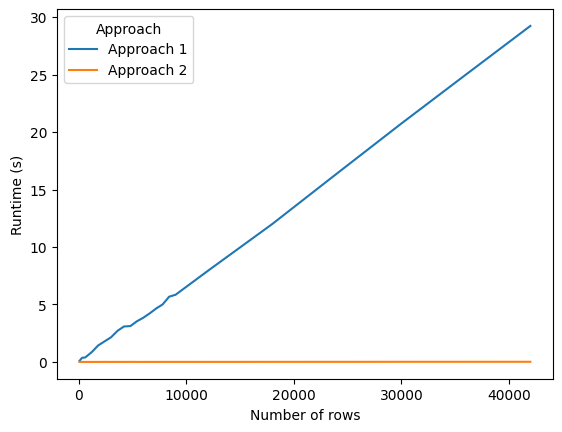

In [165]:
sns.lineplot(
    df_results_vis,
    x = 'Number of rows',
    y = 'Runtime (s)', 
    hue = 'Approach'
)

<Axes: xlabel='Number of rows', ylabel='Runtime (log_10 s)'>

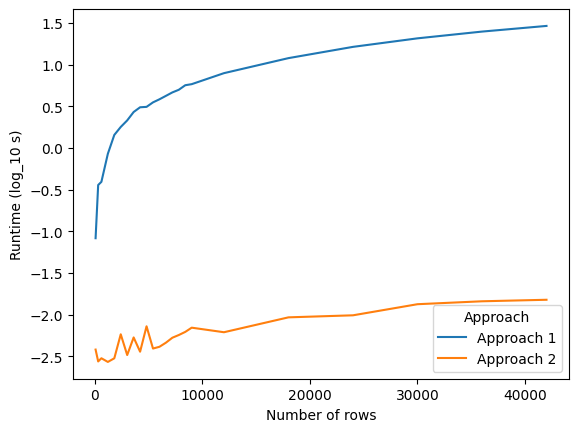

In [166]:
sns.lineplot(
    df_results_vis,
    x = 'Number of rows',
    y = 'Runtime (log_10 s)', 
    hue = 'Approach'
)